### In this notebook we perform federated learning

In federated learning each base station has access only to it's private dataset, however they collaborate together to train a model that has satifactory results on data from any other base station.

In [1]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

In [2]:
import copy

import random

from collections import OrderedDict

import numpy as np
import torch
from matplotlib import pyplot as plt

from argparse import Namespace

In [3]:
from ml.utils.data_utils import read_data, generate_time_lags, time_to_feature, handle_nans, to_Xy, \
    to_torch_dataset, to_timeseries_rep, assign_statistics, \
    to_train_val, scale_features, get_data_by_area, remove_identifiers, get_exogenous_data_by_area, handle_outliers

In [4]:
from ml.utils.train_utils import train, test

In [5]:
from ml.models.mlp import MLP
from ml.models.rnn import RNN
from ml.models.lstm import LSTM
from ml.models.gru import GRU
from ml.models.cnn import CNN
from ml.models.rnn_autoencoder import DualAttentionAutoEncoder

In [6]:
from ml.fl.defaults import create_regression_client
from ml.fl.client_proxy import SimpleClientProxy
from ml.fl.server.server import Server
from ml.utils.helpers import accumulate_metric

In [7]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("the device currently used is", device)


the device currently used is mps


In [8]:
args = Namespace(
    data_path='../dataset/cluster_split/cluster_4.csv', # dataset
    data_path_test=None , # test dataset
    test_size=0.2, # validation size
    targets=['power_output'], # the target columns
    num_lags= 8, # the number of past observations to feed as input

    identifier='GSRN', # the column name that identifies a bs

    nan_constant=0, # the constant to transform nan values
    x_scaler='minmax', # x_scaler
    y_scaler='minmax', # y_scaler
    outlier_detection=None, # whether to perform flooring and capping

    
    criterion='mse', # optimization criterion, mse or l1
    fl_rounds=20, # the number of federated rounds
    fraction=1., # the percentage of available client to consider for random selection
    aggregation="fedavg", # federated aggregation algorithm
    epochs=3, # the number of maximum local epochs
    lr=0.001, # learning rate
    optimizer='adam', # the optimizer, it can be sgd or adam
    batch_size=128, # the batch size to use
    local_early_stopping=False, # whether to use early stopping
    local_patience=50, # patience value for the early stopping parameter (if specified)
    max_grad_norm=0.0, # whether to clip grad norm
    reg1=0.0, # l1 regularization
    reg2=0.0, # l2 regularization

    cuda=True, # whether to use gpu
    
    seed=0, # reproducibility

    assign_stats=None, # whether to use statistics as exogenous data, ["mean", "median", "std", "variance", "kurtosis", "skew"]
    use_time_features=False # whether to use datetime features
)

In [9]:
print(f"Script arguments: {args}\n")

Script arguments: Namespace(data_path='../dataset/cluster_split/cluster_4.csv', data_path_test=None, test_size=0.2, targets=['power_output'], num_lags=8, identifier='GSRN', nan_constant=0, x_scaler='minmax', y_scaler='minmax', outlier_detection=None, criterion='mse', fl_rounds=20, fraction=1.0, aggregation='fedavg', epochs=3, lr=0.001, optimizer='adam', batch_size=128, local_early_stopping=False, local_patience=50, max_grad_norm=0.0, reg1=0.0, reg2=0.0, cuda=True, seed=0, assign_stats=None, use_time_features=False)



In [10]:
# Outlier detection specification
if args.outlier_detection is not None:
    outlier_columns = ['rb_down', 'rb_up', 'down', 'up']
    outlier_kwargs = {"ElBorn": (10, 90), "LesCorts": (10, 90), "PobleSec": (5, 95)}
    args.outlier_columns = outlier_columns
    args.outlier_kwargs = outlier_kwargs

In [11]:
def seed_all():
    # ensure reproducibility
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [12]:
seed_all()

### The pre-processing method is almost equivalent to centralized learning. The only difference is that the scaling operations are performed individually on each base station. In contrast, in centralized learning the scaling is performed by considering the combined data from all base stations.

In [13]:
def make_preprocessing():
    """Preprocess a given .csv"""
    # read data
    df = read_data(args.data_path)
    # handle nans
    df = handle_nans(train_data=df, constant=args.nan_constant,
                     identifier=args.identifier)
    # split to train/validation
    train_data, val_data = to_train_val(df)
    
    # handle outliers (if specified)
    if args.outlier_detection is not None:
        train_data = handle_outliers(df=train_data, columns=args.outlier_columns,
                                     identifier=args.identifier, kwargs=args.outlier_kwargs)
    
    # get X and y
    X_train, X_val, y_train, y_val = to_Xy(train_data=train_data, val_data=val_data,
                                          targets=args.targets)
    
    # scale X
    X_train, X_val, x_scalers = scale_features(train_data=X_train, val_data=X_val,
                                              scaler=args.x_scaler,
                                              per_area=True, # the features are scaled locally
                                              identifier=args.identifier)
    
    # scale y
    y_train, y_val, y_scalers = scale_features(train_data=y_train, val_data=y_val,
                                              scaler=args.y_scaler, 
                                              per_area=True,
                                              identifier=args.identifier)
    
    # generate time lags
    X_train = generate_time_lags(X_train, args.num_lags)
    X_val = generate_time_lags(X_val, args.num_lags)
    y_train = generate_time_lags(y_train, args.num_lags, is_y=True)
    y_val = generate_time_lags(y_val, args.num_lags, is_y=True)
    
    # get datetime features as exogenous data
    date_time_df_train = time_to_feature(
        X_train, args.use_time_features, identifier=args.identifier
    )
    date_time_df_val = time_to_feature(
        X_val, args.use_time_features, identifier=args.identifier
    )
    
    # get statistics as exogenous data
    stats_df_train = assign_statistics(X_train, args.assign_stats, args.num_lags,
                                       targets=args.targets, identifier=args.identifier)
    stats_df_val = assign_statistics(X_val, args.assign_stats, args.num_lags, 
                                       targets=args.targets, identifier=args.identifier)
    
    # concat the exogenous features (if any) to a single dataframe
    if date_time_df_train is not None or stats_df_train is not None:
        exogenous_data_train = pd.concat([date_time_df_train, stats_df_train], axis=1)
        # remove duplicate columns (if any)
        exogenous_data_train = exogenous_data_train.loc[:, ~exogenous_data_train.columns.duplicated()].copy()
        assert len(exogenous_data_train) == len(X_train) == len(y_train)
    else:
        exogenous_data_train = None
    if date_time_df_val is not None or stats_df_val is not None:
        exogenous_data_val = pd.concat([date_time_df_val, stats_df_val], axis=1)
        exogenous_data_val = exogenous_data_val.loc[:, ~exogenous_data_val.columns.duplicated()].copy()
        assert len(exogenous_data_val) == len(X_val) == len(y_val)
    else:
        exogenous_data_val = None

    return X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers

In [14]:
X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers= make_preprocessing()

/Users/libowen/SD3rd/RP/paper/code/Federated-Time-Series-Forecasting-main_single/ml/utils/data_utils.py:26: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)
/Users/libowen/Library/Python/3.10/lib/python/site-packages/sklearn/impute/_base.py:590: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
INFO logger 2025-10-21 13:59:38,785 | data_utils.py:393 | Observations info in 570714700000106958
INFO logger 2025-10-21 13:59:38,785 | data_utils.py:394 | 	Total number of samples:  2777
INFO logger 2025-10-21 13:59:38,785 | data_utils.py:395 | 	Number of samples for training: 2222
INFO logger 2025-10-21 13:59:38,786 | data_utils.py:396 | 	Number of samples for validation:  555
INFO logger 2025-10-21 13:59:38,786 | data_utils.py:393 

In [15]:
X_train.head()


,cluster_lag-8,power_output_lag-8,age_lag-8,wind_dir_cos_lag-8,wind_dir_sin_lag-8,hour_cos_lag-8,hour_sin_lag-8,temperature_c_lag-8,wind_speed_lag-8,cluster_lag-7,...,cluster_lag-1,power_output_lag-1,age_lag-1,wind_dir_cos_lag-1,wind_dir_sin_lag-1,hour_cos_lag-1,hour_sin_lag-1,temperature_c_lag-1,wind_speed_lag-1,GSRN
time,,,,,,,,,,,,,,,,,,,,,
2019-01-02 15:00:00,0.0,0.999767,0.0,0.742405,0.062690,0.146447,0.146447,0.269795,0.937500,0.0,...,0.0,0.825693,0.0,0.999695,0.482550,0.000000,0.500000,0.193548,0.759615,570714700000106958
2019-01-02 18:00:00,0.0,0.999710,0.0,0.888573,0.185340,0.500000,0.000000,0.281525,0.913461,0.0,...,0.0,0.600274,0.0,0.999315,0.473832,0.146447,0.146447,0.205279,0.625000,570714700000106958
2019-01-02 21:00:00,0.0,0.999024,0.0,0.904509,0.206107,0.853553,0.146447,0.272727,0.889423,0.0,...,0.0,0.378131,0.0,0.999695,0.482550,0.500000,0.000000,0.219941,0.471154,570714700000106958
2019-01-03 00:00:00,0.0,0.993803,0.0,0.985148,0.379039,1.000000,0.500000,0.258065,1.000000,0.0,...,0.0,0.009834,0.0,0.992404,0.413176,0.853553,0.146447,0.219941,0.399038,570714700000106958
2019-01-03 03:00:00,0.0,0.996226,0.0,0.996273,0.439065,0.853553,0.853553,0.240469,0.927885,0.0,...,0.0,0.132700,0.0,0.937310,0.257595,1.000000,0.500000,0.228739,0.447115,570714700000106958


In [16]:
power_output_lag_indices = [
    i for i, col in enumerate(X_train.columns)
    if col.startswith("power_output_lag")
]
print("power_output_lag is on the columns:", power_output_lag_indices)

power_output_lag is on the columns: [1, 10, 19, 28, 37, 46, 55, 64]


In [17]:
y_train.head()

,power_output,GSRN
time,,
2019-01-02 15:00:00,0.600274,570714700000106958
2019-01-02 18:00:00,0.378131,570714700000106958
2019-01-02 21:00:00,0.009834,570714700000106958
2019-01-03 00:00:00,0.132700,570714700000106958
2019-01-03 03:00:00,0.298716,570714700000106958


In [18]:
x_scalers, y_scalers

({570714700000106958: MinMaxScaler(),
  570714700000004568: MinMaxScaler(),
  570714700000004810: MinMaxScaler(),
  570714700000004964: MinMaxScaler(),
  570714700000004513: MinMaxScaler(),
  570714700000005060: MinMaxScaler(),
  570714700000004469: MinMaxScaler(),
  570714700000003585: MinMaxScaler(),
  570714700000005053: MinMaxScaler(),
  570714700000010750: MinMaxScaler(),
  570714700000010767: MinMaxScaler(),
  570714700000004728: MinMaxScaler(),
  570714700000004704: MinMaxScaler(),
  570714700000005039: MinMaxScaler(),
  570714700000009655: MinMaxScaler(),
  570714700000009945: MinMaxScaler(),
  570714700000005091: MinMaxScaler(),
  570714700000004995: MinMaxScaler(),
  570714700000004940: MinMaxScaler(),
  570714700000008450: MinMaxScaler(),
  570714700000006258: MinMaxScaler(),
  570714700000006296: MinMaxScaler(),
  570714700000008252: MinMaxScaler(),
  570714700000006029: MinMaxScaler(),
  570714700000006289: MinMaxScaler(),
  570714700000012501: MinMaxScaler(),
  5707147000

### Postprocessing in a same manner with centalized learning

In [19]:
def make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers):
    """Make data ready to be fed into ml algorithms"""
    # if there are more than one specified areas, get the data per area
    if X_train[args.identifier].nunique() != 1:
        area_X_train, area_X_val, area_y_train, area_y_val = get_data_by_area(X_train, X_val,
                                                                              y_train, y_val, 
                                                                              identifier=args.identifier)
    else:
        area_X_train, area_X_val, area_y_train, area_y_val = None, None, None, None

    # Get the exogenous data per area.
    if exogenous_data_train is not None:
        exogenous_data_train, exogenous_data_val = get_exogenous_data_by_area(exogenous_data_train,
                                                                              exogenous_data_val)
    # transform to np
    if area_X_train is not None:
        for area in area_X_train:
            tmp_X_train, tmp_y_train, tmp_X_val, tmp_y_val = remove_identifiers(
                area_X_train[area], area_y_train[area], area_X_val[area], area_y_val[area])
            tmp_X_train, tmp_y_train = tmp_X_train.to_numpy(), tmp_y_train.to_numpy()
            tmp_X_val, tmp_y_val = tmp_X_val.to_numpy(), tmp_y_val.to_numpy()
            area_X_train[area] = tmp_X_train
            area_X_val[area] = tmp_X_val
            area_y_train[area] = tmp_y_train
            area_y_val[area] = tmp_y_val
    
    if exogenous_data_train is not None:
        for area in exogenous_data_train:
            exogenous_data_train[area] = exogenous_data_train[area].to_numpy()
            exogenous_data_val[area] = exogenous_data_val[area].to_numpy()
    
    # remove identifiers from features, targets
    X_train, y_train, X_val, y_val = remove_identifiers(X_train, y_train, X_val, y_val)
    assert len(X_train.columns) == len(X_val.columns)
    
    num_features = len(X_train.columns) // args.num_lags
    
    # to timeseries representation
    X_train = to_timeseries_rep(X_train.to_numpy(), num_lags=args.num_lags,
                                            num_features=num_features)
    X_val = to_timeseries_rep(X_val.to_numpy(), num_lags=args.num_lags,
                                          num_features=num_features)
    
    if area_X_train is not None:
        area_X_train = to_timeseries_rep(area_X_train, num_lags=args.num_lags,
                                                     num_features=num_features)
        area_X_val = to_timeseries_rep(area_X_val, num_lags=args.num_lags,
                                                   num_features=num_features)
    
    # transform targets to numpy
    y_train, y_val = y_train.to_numpy(), y_val.to_numpy()
    
    if exogenous_data_train is not None:
        exogenous_data_train_combined, exogenous_data_val_combined = [], []
        for area in exogenous_data_train:
            exogenous_data_train_combined.extend(exogenous_data_train[area])
            exogenous_data_val_combined.extend(exogenous_data_val[area])
        exogenous_data_train_combined = np.stack(exogenous_data_train_combined)
        exogenous_data_val_combined = np.stack(exogenous_data_val_combined)
        exogenous_data_train["all"] = exogenous_data_train_combined
        exogenous_data_val["all"] = exogenous_data_val_combined
    return X_train, X_val, y_train, y_val, area_X_train, area_X_val, area_y_train, area_y_val, exogenous_data_train, exogenous_data_val

In [20]:
X_train, X_val, y_train, y_val, client_X_train, client_X_val, client_y_train, client_y_val, exogenous_data_train, exogenous_data_val = make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers)

In [ ]:
import numpy as np
import pandas as pd

valid_clients = []

for gsrn in list(client_X_train.keys()):
    y_train_df = client_y_train[gsrn]
    y_val_df = client_y_val[gsrn]

    # make sure y_train and y_val are 1D arrays
    y_train = np.array(y_train_df).flatten()
    y_val = np.array(y_val_df).flatten()

    # 1️ all 0 (train and val)
    if np.all(y_train == 0) and np.all(y_val == 0):
        print(f"⚠️ Skipping {gsrn}: all targets are 0 in train and val")
        continue

    # 2️ too few non-zero targets (train)
    if np.count_nonzero(y_train) < 10:
        print(f"⚠️ Skipping {gsrn}: too few non-zero targets in train ({np.count_nonzero(y_train)})")
        continue

    # 3️ all 0 (val)
    if np.all(y_val == 0):
        print(f"⚠️ Skipping {gsrn}: all val targets are 0")
        continue

    # 4️ constant value (no variation)
    if np.std(y_train) == 0:
        print(f"⚠️ Skipping {gsrn}: y_train is constant")
        continue

    # 5️ val max too low (no significant power fluctuations)
    if np.max(y_val) < 0.1:
        print(f"⚠️ Skipping {gsrn}: y_val max too low ({np.max(y_val):.4f})")
        continue
    
    # 6️ val std too low (no variation)
    if np.std(y_val) < 0.05:
        print(f"⚠️ Skipping {gsrn}: y_val std too low ({np.std(y_val):.4f})")
        continue

    valid_clients.append(gsrn)

print(f" {len(valid_clients)} valid clients remaining after filtering.")

⚠️ Skipping 570714700000004568: all val targets are 0
⚠️ Skipping 570714700000004964: y_val max too low (0.0129)
⚠️ Skipping 570714700000005060: y_val max too low (0.0060)
⚠️ Skipping 570714700000004469: y_val std too low (0.0143)
⚠️ Skipping 570714700000004704: y_val std too low (0.0133)
⚠️ Skipping 570714700000006296: all val targets are 0
⚠️ Skipping 570714700000008252: y_val std too low (0.0390)
⚠️ Skipping 570714700000006029: all val targets are 0
⚠️ Skipping 570714700000006289: too few non-zero targets in train (8)
⚠️ Skipping 570715000000083464: all val targets are 0
⚠️ Skipping 570714700000006982: y_val std too low (0.0316)
⚠️ Skipping 570714700000005626: y_val std too low (0.0199)
⚠️ Skipping 570714700000005619: y_val std too low (0.0333)
⚠️ Skipping 570714700000006890: all targets are 0 in train and val
✅ 61 valid clients remaining after filtering.


In [22]:
removed_clients = {}

# inside the loop:
removed_clients[gsrn] = "constant target"

In [23]:
client_X_train.keys()

dict_keys([570714700000106958, 570714700000004568, 570714700000004810, 570714700000004964, 570714700000004513, 570714700000005060, 570714700000004469, 570714700000003585, 570714700000005053, 570714700000010750, 570714700000010767, 570714700000004728, 570714700000004704, 570714700000005039, 570714700000009655, 570714700000009945, 570714700000005091, 570714700000004995, 570714700000004940, 570714700000008450, 570714700000006258, 570714700000006296, 570714700000008252, 570714700000006029, 570714700000006289, 570714700000012501, 570714700000005886, 570714700000013348, 570714700000013331, 570714700000013324, 570715000000083464, 571313174001764448, 570714700000008764, 570714700000007828, 570714700000009273, 570714700000009280, 570714700000007194, 570714700000008092, 570714700000005923, 570714700000008627, 570714700000006982, 570714700000008962, 570714700000009556, 570714700000009952, 570714700000010194, 570714700000010217, 570714700000010200, 570714700000006081, 570714700000006333, 570714700

In [24]:
client_X_val.keys()

dict_keys([570714700000106958, 570714700000004568, 570714700000004810, 570714700000004964, 570714700000004513, 570714700000005060, 570714700000004469, 570714700000003585, 570714700000005053, 570714700000010750, 570714700000010767, 570714700000004728, 570714700000004704, 570714700000005039, 570714700000009655, 570714700000009945, 570714700000005091, 570714700000004995, 570714700000004940, 570714700000008450, 570714700000006258, 570714700000006296, 570714700000008252, 570714700000006029, 570714700000006289, 570714700000012501, 570714700000005886, 570714700000013348, 570714700000013331, 570714700000013324, 570715000000083464, 571313174001764448, 570714700000008764, 570714700000007828, 570714700000009273, 570714700000009280, 570714700000007194, 570714700000008092, 570714700000005923, 570714700000008627, 570714700000006982, 570714700000008962, 570714700000009556, 570714700000009952, 570714700000010194, 570714700000010217, 570714700000010200, 570714700000006081, 570714700000006333, 570714700

In [25]:
for client in valid_clients:
    print(f"\n Valid Client: {client}")
    print(f"X_train shape: {client_X_train[client].shape}, y_train shape: {client_y_train[client].shape}")
    print(f"X_val shape: {client_X_val[client].shape}, y_val shape: {client_y_val[client].shape}")


 Valid Client: 570714700000106958
X_train shape: (2214, 8, 9, 1), y_train shape: (2214, 1)
X_val shape: (547, 8, 9, 1), y_val shape: (547, 1)

 Valid Client: 570714700000004810
X_train shape: (2214, 8, 9, 1), y_train shape: (2214, 1)
X_val shape: (547, 8, 9, 1), y_val shape: (547, 1)

 Valid Client: 570714700000004513
X_train shape: (2214, 8, 9, 1), y_train shape: (2214, 1)
X_val shape: (547, 8, 9, 1), y_val shape: (547, 1)

 Valid Client: 570714700000003585
X_train shape: (2214, 8, 9, 1), y_train shape: (2214, 1)
X_val shape: (547, 8, 9, 1), y_val shape: (547, 1)

 Valid Client: 570714700000005053
X_train shape: (2214, 8, 9, 1), y_train shape: (2214, 1)
X_val shape: (547, 8, 9, 1), y_val shape: (547, 1)

 Valid Client: 570714700000010750
X_train shape: (2214, 8, 9, 1), y_train shape: (2214, 1)
X_val shape: (547, 8, 9, 1), y_val shape: (547, 1)

 Valid Client: 570714700000010767
X_train shape: (2214, 8, 9, 1), y_train shape: (2214, 1)
X_val shape: (547, 8, 9, 1), y_val shape: (547, 1)

In [26]:
def get_input_dims(X_train, exogenous_data_train):
    if args.model_name == "mlp":
        input_dim = X_train.shape[1] * X_train.shape[2]
    else:
        input_dim = X_train.shape[2]
    
    if exogenous_data_train is not None:
        if len(exogenous_data_train) == 1:
            cid = next(iter(exogenous_data_train.keys()))
            exogenous_dim = exogenous_data_train[cid].shape[1]
        else:
            exogenous_dim = exogenous_data_train["all"].shape[1]
    else:
        exogenous_dim = 0
    
    return input_dim, exogenous_dim

In [27]:
def get_model(model: str,
              input_dim: int,
              out_dim: int,
              lags: int = 10,
              exogenous_dim: int = 0,
              seed=0):
    if model == "mlp":
        model = MLP(input_dim=input_dim, layer_units=[256, 128, 64], num_outputs=out_dim)
    elif model == "rnn":
        model = RNN(input_dim=input_dim, rnn_hidden_size=128, num_rnn_layers=1, rnn_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "lstm":
        model = LSTM(input_dim=input_dim, lstm_hidden_size=128, num_lstm_layers=1, lstm_dropout=0.0,
                     layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "gru":
        model = GRU(input_dim=input_dim, gru_hidden_size=128, num_gru_layers=1, gru_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "cnn":
        model = CNN(num_features=input_dim, lags=lags, exogenous_dim=exogenous_dim, out_dim=out_dim)
    elif model == "da_encoder_decoder":
        model = DualAttentionAutoEncoder(input_dim=input_dim, architecture="lstm", matrix_rep=True)
    else:
        raise NotImplementedError("Specified model is not implemented. Plese define your own model or choose one from ['mlp', 'rnn', 'lstm', 'gru', 'cnn', 'da_encoder_decoder']")
    return model

In [28]:
# define the model
args.model_name = "lstm"

input_dim, exogenous_dim = get_input_dims(X_train, exogenous_data_train)

print(input_dim, exogenous_dim)

model = get_model(model=args.model_name,
                  input_dim=input_dim,
                  out_dim=1, # output dimension is 1 for univariate forecasting
                  lags=args.num_lags,
                #   exogenous_dim=exogenous_dim,
                    exogenous_dim=0,
                  seed=args.seed)

9 0


In [29]:
model

LSTM(
  (lstm): LSTM(9, 128, batch_first=True)
  (MLP_layers): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
)

### Fit function initiates the training process of every base station local model and then performs parameters aggregation on a central server for N specified federated epochs.

In [30]:
def fit(model, X_train, y_train, X_val, y_val, 
        exogenous_data_train=None, exogenous_data_val=None, 
        idxs=  [1], # the indices of our targets in X
        log_per=1,
        client_creation_fn = None, # client specification
        local_train_params=None, # local params
        aggregation_params=None, # aggregation params
        use_carbontracker=True
       ):
    # client creation definition
    if client_creation_fn is None:
        client_creation_fn = create_regression_client
    # local params
    if local_train_params is None:
        local_train_params = {
            "epochs": args.epochs, "optimizer": args.optimizer, "lr": args.lr,
            "criterion": args.criterion, "early_stopping": args.local_early_stopping,
            "patience": args.local_patience, "device": device
        }
    
    train_loaders, val_loaders = [], []
    
 
    
    # get data per client
    for client in valid_clients:
        if client == "all":
            continue
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(X_train[client][0][0])
        
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                X_train[client], y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                #exogenous_data=tmp_exogenous_data_train,
                exogenous_data=None,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False,
            )
        )
        val_loaders.append(
            to_torch_dataset(
                X_val[client], y_val[client],
                num_lags=args.num_lags,
                # exogenous_data=tmp_exogenous_data_val,
                 exogenous_data=None,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False,
            )
            
        )
        
    # create clients with their local data
    cids = valid_clients
    clients = [
        client_creation_fn(
            cid=cid, # client id
            model=model, # the global model
            train_loader=train_loader, # the local train loader
            test_loader=val_loader, # the local val loader
            local_params=local_train_params # local parameters
        )
        for cid, train_loader, val_loader in zip(valid_clients, train_loaders, val_loaders)
    ]
    
    # represent clients to server
    client_proxies = [
        SimpleClientProxy(cid, client) for cid, client in zip(cids, clients)
    ]
    
    # represent the server
    server = Server(
        client_proxies=client_proxies, # the client representations
        aggregation=args.aggregation, # the aggregation algorithm
        aggregation_params=aggregation_params, # aggregation specific params
        local_params_fn=None, # we can change the local params on demand
    )
    # Note that the client manager instance will be initialized automatically. You can define your own client manager.

    # train with FL
    model_params, history = server.fit(args.fl_rounds, args.fraction, use_carbontracker=use_carbontracker)
    
    params_dict = zip(model.state_dict().keys(), model_params)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model = copy.deepcopy(model)
    model.load_state_dict(state_dict, strict=True)
    
    return model, history

In [31]:
# federated local params
local_train_params = {"epochs": args.epochs, "optimizer": args.optimizer, "lr": args.lr,
                      "criterion": args.criterion, "early_stopping": args.local_early_stopping,
                      "patience": args.local_patience, "device": device
                      }

The traning takes 11m 38,7s

In [32]:
global_model, history = fit(
    model,
    {cid: client_X_train[cid] for cid in valid_clients},
    {cid: client_y_train[cid] for cid in valid_clients},
    {cid: client_X_val[cid] for cid in valid_clients},
    {cid: client_y_val[cid] for cid in valid_clients},
    local_train_params=local_train_params
)


INFO logger 2025-10-21 13:59:42,592 | server.py:62 | Initializing client manager...
INFO logger 2025-10-21 13:59:42,592 | server.py:69 | Registering clients...
INFO logger 2025-10-21 13:59:42,593 | client_manager.py:66 | Registered client with id: 570714700000106958
INFO logger 2025-10-21 13:59:42,593 | client_manager.py:66 | Registered client with id: 570714700000004810
INFO logger 2025-10-21 13:59:42,593 | client_manager.py:66 | Registered client with id: 570714700000004513
INFO logger 2025-10-21 13:59:42,593 | client_manager.py:66 | Registered client with id: 570714700000003585
INFO logger 2025-10-21 13:59:42,594 | client_manager.py:66 | Registered client with id: 570714700000005053
INFO logger 2025-10-21 13:59:42,594 | client_manager.py:66 | Registered client with id: 570714700000010750
INFO logger 2025-10-21 13:59:42,594 | client_manager.py:66 | Registered client with id: 570714700000010767
INFO logger 2025-10-21 13:59:42,595 | client_manager.py:66 | Registered client with id: 570

INFO logger 2025-10-21 13:59:50,031 | server.py:86 | Starting FL rounds
INFO logger 2025-10-21 13:59:50,032 | client_manager.py:88 | Parameter c=1.0. Sampled 61 client(s): [570714700000009273, 570714700000008016, 570714700000007637, 570714700000007194, 570714700000004513, 570714700000012501, 570714700000009952, 570714700000009556, 570714700000009280, 570714700000005961, 570714700000013331, 570714700000008962, 570714700000008764, 570714700000006333, 570714700000004940, 570714700000009426, 570714700000005039, 570714700000013348, 570715000000088513, 570714700000010767, 570714700000006074, 570714700000008702, 570714700000010217, 570714700000009655, 570714700000002168, 570714700000005817, 570714700000005053, 571313174001764448, 570714700000005978, 570714700000010200, 570714700000005091, 570714700000012624, 570714700000009945, 570714700000006081, 570714700000013324, 570714700000002151, 570714700000005886, 570714700000006258, 570714700000008450, 570714700000006067, 570714700000007682, 5707147

In [33]:
global_model.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[-0.0007,  0.1093, -0.0727,  ...,  0.0406,  0.1026,  0.0640],
                      [ 0.0234,  0.0718, -0.0174,  ...,  0.0363,  0.0391,  0.1165],
                      [-0.0599,  0.0352,  0.0321,  ...,  0.1023,  0.1092,  0.1861],
                      ...,
                      [-0.0457,  0.0195, -0.0705,  ...,  0.1578, -0.0262,  0.1576],
                      [ 0.0744,  0.1155, -0.0551,  ..., -0.0286, -0.0375,  0.0286],
                      [-0.0855, -0.0233, -0.0668,  ...,  0.0819, -0.0669,  0.0561]])),
             ('lstm.weight_hh_l0',
              tensor([[ 0.0719,  0.1309,  0.0049,  ..., -0.1022, -0.0932,  0.1229],
                      [-0.0459,  0.0450, -0.0268,  ..., -0.0029,  0.0524,  0.0008],
                      [-0.1282,  0.0267, -0.0539,  ..., -0.1688, -0.0677,  0.0438],
                      ...,
                      [ 0.0233,  0.1486,  0.0175,  ..., -0.0412, -0.0518,  0.0679],
                      [-0.0646,  

In [34]:
history


History (client, train losses):
	570714700000009273: {1: 0.00014478667927762896, 2: 0.0001545757704768616, 3: 0.00011345788049019449, 4: 0.00010770734617454627, 5: 0.00010249716824538124, 6: 9.76017725089432e-05, 7: 8.729616976776366e-05, 8: 8.119747056116795e-05, 9: 7.668575574833203e-05, 10: 7.558760759879203e-05, 11: 7.433938863666184e-05, 12: 7.24187051387741e-05, 13: 7.022991179141141e-05, 14: 6.779576058633282e-05, 15: 6.587463161843309e-05, 16: 6.402867992157024e-05, 17: 5.032774502648732e-05, 18: 4.995450572646623e-05, 19: 4.962405421019825e-05, 20: 4.881498620587939e-05}
	570714700000008016: {1: 0.00023633814118163157, 2: 0.00016923229964727632, 3: 0.00014753365180814385, 4: 0.0001359555378973538, 5: 0.00012931472839755633, 6: 0.00012636413190315302, 7: 0.00012518617100744443, 8: 0.00012426040082321902, 9: 0.00012344571651576227, 10: 0.00012280770881200763, 11: 0.0001222185448549062, 12: 0.00012169847586263701, 13: 0.00012121659803667796, 14: 0.00012075676592849296, 15: 0.000

In [35]:
import h5py
from collections import OrderedDict
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# extract MinMaxScaler attributes
def get_minmax_attrs(scaler: MinMaxScaler):
    return {
        "min_": scaler.min_,
        "scale_": scaler.scale_,
        "data_min_": scaler.data_min_,
        "data_max_": scaler.data_max_,
        "data_range_": scaler.data_range_,
        "n_features_in_": np.array([scaler.n_features_in_]),
        "n_samples_seen_": np.array([scaler.n_samples_seen_]),
        "feature_names_in_": getattr(scaler, "feature_names_in_", None)
    }

# process a dict of MinMaxScalers
def build_scaler_state_dict(scaler_dict):
    state_dict = {}
    for client_id, scaler in scaler_dict.items():
        state_dict[client_id] = get_minmax_attrs(scaler)
    return state_dict

# save the scalers to h5 file
class ScalerSerializer:
    def __init__(self, x_scaler_state, y_scaler_state, save_path: str):
        self.save_path = save_path
        self.x_scaler = x_scaler_state
        self.y_scaler = y_scaler_state

    def save(self):
        with h5py.File(self.save_path, "w") as f:
            # save x_scalers
            x_group = f.create_group("x_scaler", track_order=True)
            for client_id, attrs in self.x_scaler.items():
                client_group = x_group.create_group(str(client_id))
                for k, v in attrs.items():
                    client_group.create_dataset(k, data=v)

            # save y_scalers
            y_group = f.create_group("y_scaler", track_order=True)
            for client_id, attrs in self.y_scaler.items():
                client_group = y_group.create_group(str(client_id))
                for k, v in attrs.items():
                    client_group.create_dataset(k, data=v)

x_scaler_attrs = build_scaler_state_dict(x_scalers)
y_scaler_attrs = build_scaler_state_dict(y_scalers)

scaler_serializer = ScalerSerializer(
    x_scaler_attrs,
    y_scaler_attrs,
    save_path="model_checkpoint/scalers_cluster4.h5"
)
scaler_serializer.save()

print(" Scalers saved to model_checkpoint/scalers_cluster4.h5")

 Scalers saved to model_checkpoint/scalers_cluster4.h5


In [36]:
import matplotlib.pyplot as plt

def plot_fl_training_metrics(history):
    metrics_to_plot = ["MSE", "RMSE", "MAE", "R^2", "NRMSE"]
    rounds = list(range(1, len(next(iter(history.global_test_metrics.values()))) + 1))

    plt.figure(figsize=(16, 10))

    for i, metric in enumerate(metrics_to_plot, 1):
        if metric in history.global_test_metrics:
            plt.subplot(2, 3, i)
            plt.plot(rounds, history.global_test_metrics[metric], marker='o', label=f"Test {metric.upper()}")
            if metric in history.global_train_metrics:
                plt.plot(rounds, history.global_train_metrics[metric], marker='x', label=f"Train {metric.upper()}")
            plt.title(metric.upper())
            plt.xlabel("Round")
            plt.ylabel(metric.upper())
            plt.grid(True)
            plt.legend()

    plt.tight_layout()
    plt.show()

In [37]:
for gsrn in valid_clients:
    y_val = np.array(client_y_val[gsrn]).flatten()
    print(f"{gsrn}: max={np.max(y_val):.4f}, std={np.std(y_val):.4f}")

570714700000106958: max=0.9530, std=0.1907
570714700000004810: max=0.9523, std=0.2220
570714700000004513: max=0.9392, std=0.1966
570714700000003585: max=1.0190, std=0.1978
570714700000005053: max=1.0004, std=0.2197
570714700000010750: max=0.9769, std=0.2205
570714700000010767: max=0.9635, std=0.2325
570714700000004728: max=0.8569, std=0.1923
570714700000005039: max=0.8752, std=0.1799
570714700000009655: max=0.8670, std=0.1842
570714700000009945: max=0.8719, std=0.1684
570714700000005091: max=0.9750, std=0.2711
570714700000004995: max=0.6556, std=0.0935
570714700000004940: max=0.9373, std=0.2112
570714700000008450: max=0.8846, std=0.2083
570714700000006258: max=1.0541, std=0.2477
570714700000012501: max=0.9972, std=0.2036
570714700000005886: max=0.7572, std=0.1469
570714700000013348: max=0.8443, std=0.1843
570714700000013331: max=0.8469, std=0.1792
570714700000013324: max=0.8908, std=0.1960
571313174001764448: max=0.8136, std=0.1916
570714700000008764: max=0.7309, std=0.1048
57071470000

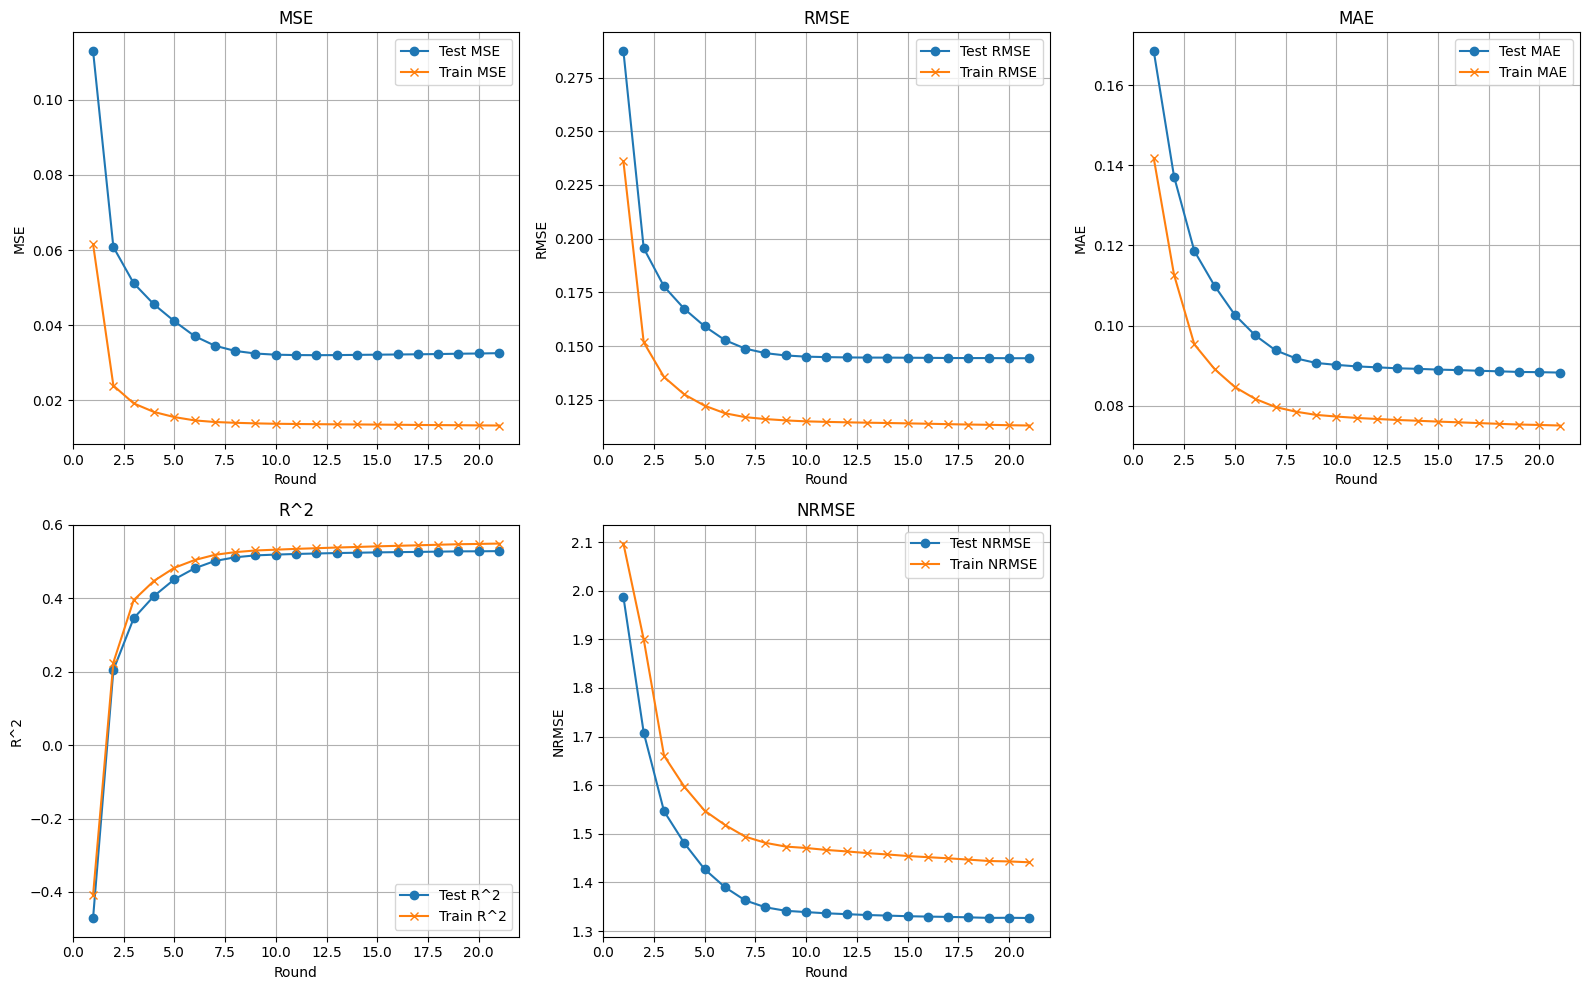

In [38]:
plot_fl_training_metrics(history)

In [39]:
def transform_preds(y_pred_train, y_pred_val):
    if not isinstance(y_pred_train, np.ndarray):
        y_pred_train = y_pred_train.cpu().numpy()
    if not isinstance(y_pred_val, np.ndarray):
        y_pred_val = y_pred_val.cpu().numpy()
    return y_pred_train, y_pred_val

def round_predictions(y_pred_train, y_pred_val, dims):
    # round to closest integer
    if dims is None or len(dims) == 0:
        return y_pred_train, y_pred_val
    for dim in dims:
        y_pred_train[:, dim] = np.rint(y_pred_train[:, dim])
        y_pred_val[:, dim] = np.rint(y_pred_val[:, dim])
    return y_pred_train, y_pred_val

def inverse_transform(y_train, y_val, y_pred_train, y_pred_val,
                     y_scaler=None, 
                     round_preds=False, dims=None):
    y_pred_train, y_pred_val = transform_preds(y_pred_train, y_pred_val)
    
    if y_scaler is not None:
        y_train = y_scaler.inverse_transform(y_train)
        y_val = y_scaler.inverse_transform(y_val)
        y_pred_train = y_scaler.inverse_transform(y_pred_train)
        y_pred_val = y_scaler.inverse_transform(y_pred_val)
    
    # to zeroes
    y_pred_train[y_pred_train < 0.] = 0.
    y_pred_val[y_pred_val < 0.] = 0.
    
    if round_preds:
        y_pred_train, y_pred_val = round_predictions(y_pred_train, y_pred_val, dims)
    
    return y_train, y_val, y_pred_train, y_pred_val

In [40]:
def make_plot(y_true, y_pred, 
              title, 
              feature_names=None, 
              client=None):
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(y_pred.shape[1])]
    assert len(feature_names) == y_pred.shape[1]

    for i in range(y_pred.shape[1]):
        plt.figure(figsize=(8, 6))
        plt.ticklabel_format(style='plain')
        plt.plot(y_true[:, i], label="Actual")
        plt.plot(y_pred[:, i], label="Predicted")
        if client is not None:
            plt.title(f"[{client} {title}] {feature_names[i]} prediction")
        else:
            plt.title(f"[{title}] {feature_names[i]} prediction")
        plt.legend()
        plt.show()
        plt.close()

### During the inference stage we inverse the transformations we applied during preprocessing

In [41]:
def inference(
    model, # the global model
    client_X_train, # train data per client
    client_y_train,
    client_X_val, # val data per client
    client_y_val,
    exogenous_data_train, # exogenous data per client
    exogenous_data_val,
    y_scalers, # the scalers used to transform the targets
    idxs=[1],
    apply_round=True, # round to closest integer
    round_dimensions=[0], # the dimensions to apply rounding
    plot=True, # plot predictions
    plot_clients: list = None,  # 指定要画图的client，比如 ['GSRN_001', 'GSRN_002']
    max_plot_clients: int = 5,
):
    # load per client data to torch
    train_loaders, val_loaders = [], []
    
    # get data per client
    for client in valid_clients:
        if client == "all":
            continue
        assert client in list(y_scalers.keys())
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(client_X_train[client][0][0])
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                client_X_train[client], client_y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                exogenous_data=tmp_exogenous_data_train,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
        )
        val_loaders.append(
            to_torch_dataset(
                client_X_val[client], client_y_val[client],
                num_lags=args.num_lags,
                exogenous_data=tmp_exogenous_data_val,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
            
        )
        
    # get client ids
    cids = valid_clients
        
    # predict per client using the global model
    y_preds_train, y_preds_val = dict(), dict()
    for cid, train_loader, val_loader in zip(cids, train_loaders, val_loaders):
        print(f"Prediction on {cid}")
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, y_pred_train = test(
            model, train_loader, None, device=device
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, y_pred_val = test(
            model, val_loader, None, device=device
        )
        y_preds_train[cid] = y_pred_train
        y_preds_val[cid] = y_pred_val
    
    for cid in cids:
        y_train, y_val = client_y_train[cid], client_y_val[cid]
        y_pred_train, y_pred_val = y_preds_train[cid], y_preds_val[cid]
        
        y_scaler = y_scalers[cid]
        y_train, y_val, y_pred_train, y_pred_val = inverse_transform(
            y_train, y_val, y_pred_train, y_pred_val,
            y_scaler, round_preds=apply_round, dims=round_dimensions
        )
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, train_res_per_dim = accumulate_metric(
            y_train, y_pred_train, True, return_all=True
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, val_res_per_dim = accumulate_metric(
            y_val, y_pred_val, True, return_all=True
        )
        
        print(f"\nFinal Prediction on {cid} (Inference Stage)")
        print(f"[Train]: mse: {train_mse}, "
              f"rmse: {train_rmse}, mae {train_mae}, r2: {train_r2}, nrmse: {train_nrmse}")
        print(f"[Val]: mse: {val_mse}, "
              f"rmse: {val_rmse}, mae {val_mae}, r2: {val_r2}, nrmse: {val_nrmse}\n\n")
        
        if plot:
            if (plot_clients is not None and cid not in plot_clients):
                continue
            if plot_clients is None and cids.index(cid) >= max_plot_clients:
                continue

            make_plot(y_train, y_pred_train, title="Train", feature_names=args.targets, client=cid)
            make_plot(y_val, y_pred_val, title="Val", feature_names=args.targets, client=cid)

Prediction on 570714700000106958
Prediction on 570714700000004810
Prediction on 570714700000004513
Prediction on 570714700000003585
Prediction on 570714700000005053
Prediction on 570714700000010750
Prediction on 570714700000010767
Prediction on 570714700000004728
Prediction on 570714700000005039
Prediction on 570714700000009655
Prediction on 570714700000009945
Prediction on 570714700000005091
Prediction on 570714700000004995
Prediction on 570714700000004940
Prediction on 570714700000008450
Prediction on 570714700000006258
Prediction on 570714700000012501
Prediction on 570714700000005886
Prediction on 570714700000013348
Prediction on 570714700000013331
Prediction on 570714700000013324
Prediction on 571313174001764448
Prediction on 570714700000008764
Prediction on 570714700000007828
Prediction on 570714700000009273
Prediction on 570714700000009280
Prediction on 570714700000007194
Prediction on 570714700000008092
Prediction on 570714700000005923
Prediction on 570714700000008627
Prediction

INFO logger 2025-10-21 14:18:56,347 | helpers.py:60 | Metrics for dimension: 0
	mse: 330.09576416015625, rmse: 18.168537755145742, mae: 11.24592113494873, r^2: 0.6998951435089111, nrmse: 0.7757427644917214
INFO logger 2025-10-21 14:18:56,348 | helpers.py:60 | Metrics for dimension: 0
	mse: 294.75244140625, rmse: 17.168355815460316, mae: 10.873112678527832, r^2: 0.6628173589706421, nrmse: 0.7484612115419476



Final Prediction on 570714700000106958 (Inference Stage)
[Train]: mse: 330.09576416015625, rmse: 18.168537755145742, mae 11.24592113494873, r2: 0.6998951435089111, nrmse: 0.7757427644917214
[Val]: mse: 294.75244140625, rmse: 17.168355815460316, mae 10.873112678527832, r2: 0.6628173589706421, nrmse: 0.7484612115419476




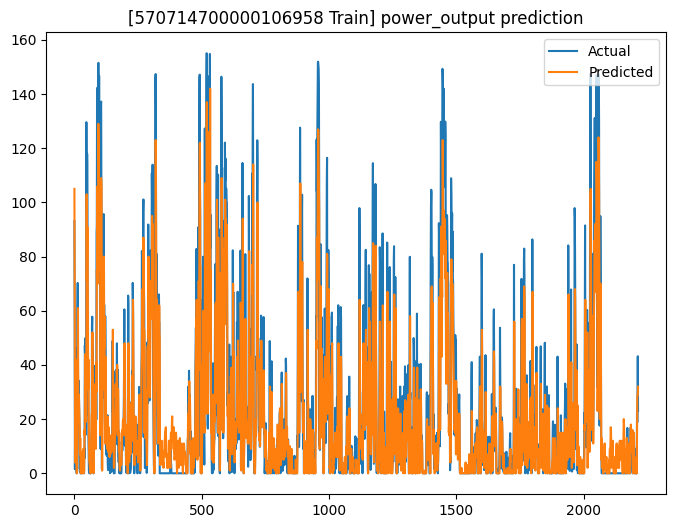

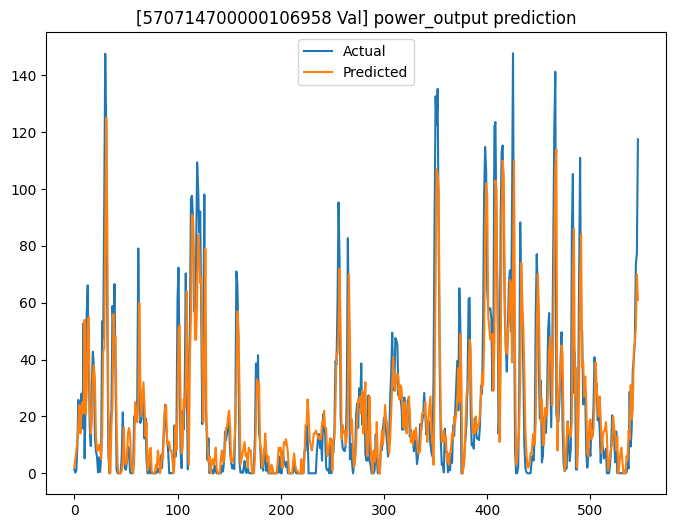

INFO logger 2025-10-21 14:18:56,482 | helpers.py:60 | Metrics for dimension: 0
	mse: 312.85382080078125, rmse: 17.687674262061172, mae: 11.047663688659668, r^2: 0.7041925191879272, nrmse: 0.7642892940655206
INFO logger 2025-10-21 14:18:56,484 | helpers.py:60 | Metrics for dimension: 0
	mse: 366.54827880859375, rmse: 19.14545060343563, mae: 13.000190734863281, r^2: 0.6905118823051453, nrmse: 0.7281484840440342



Final Prediction on 570714700000004810 (Inference Stage)
[Train]: mse: 312.85382080078125, rmse: 17.687674262061172, mae 11.047663688659668, r2: 0.7041925191879272, nrmse: 0.7642892940655206
[Val]: mse: 366.54827880859375, rmse: 19.14545060343563, mae 13.000190734863281, r2: 0.6905118823051453, nrmse: 0.7281484840440342




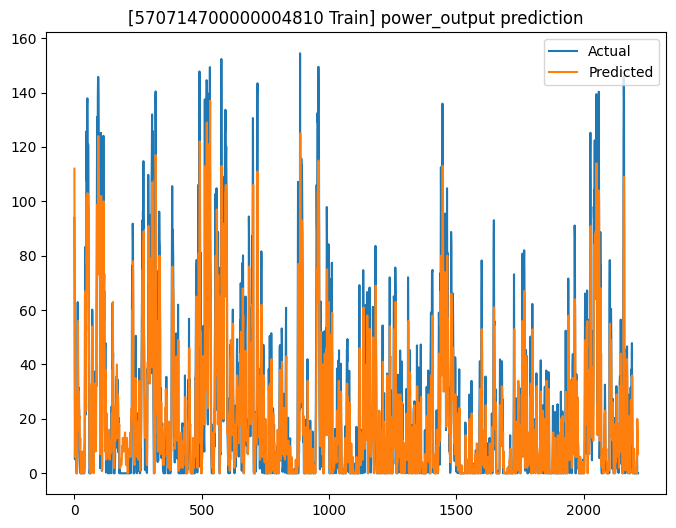

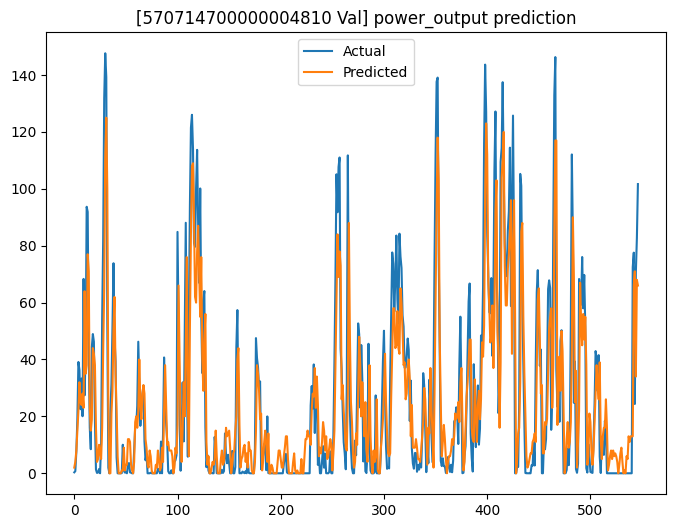

INFO logger 2025-10-21 14:18:56,713 | helpers.py:60 | Metrics for dimension: 0
	mse: 225.88133239746094, rmse: 15.029349034388048, mae: 9.676244735717773, r^2: 0.6915978193283081, nrmse: 0.7562486014439357
INFO logger 2025-10-21 14:18:56,714 | helpers.py:60 | Metrics for dimension: 0
	mse: 300.88714599609375, rmse: 17.34609886966213, mae: 11.925090789794922, r^2: 0.6761209964752197, nrmse: 0.7316462155165447



Final Prediction on 570714700000004513 (Inference Stage)
[Train]: mse: 225.88133239746094, rmse: 15.029349034388048, mae 9.676244735717773, r2: 0.6915978193283081, nrmse: 0.7562486014439357
[Val]: mse: 300.88714599609375, rmse: 17.34609886966213, mae 11.925090789794922, r2: 0.6761209964752197, nrmse: 0.7316462155165447




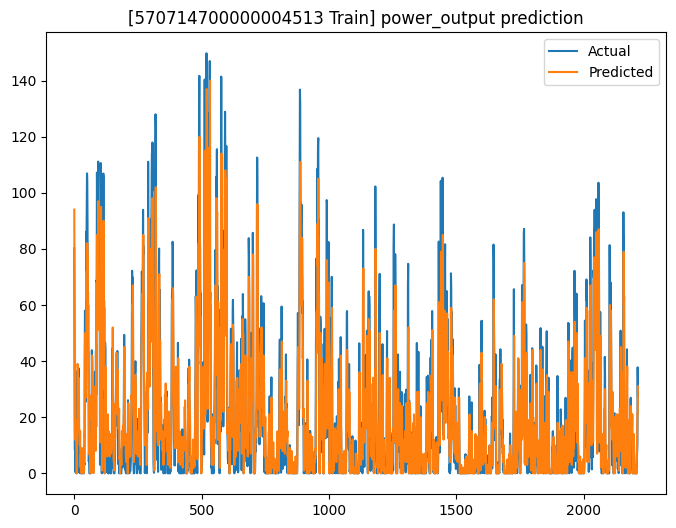

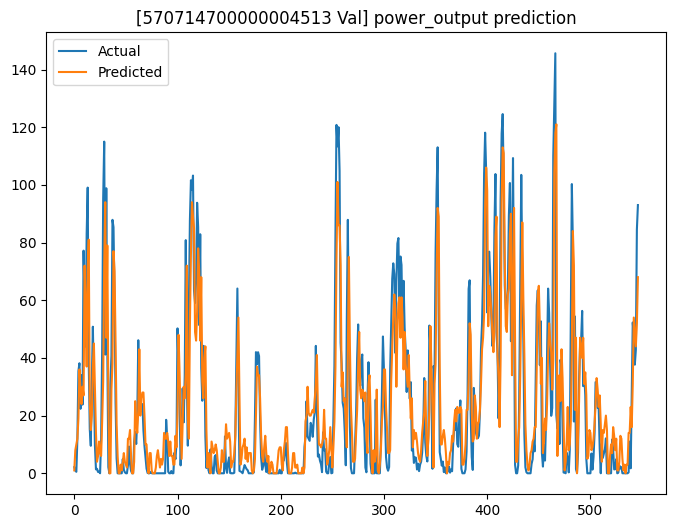

INFO logger 2025-10-21 14:18:56,837 | helpers.py:60 | Metrics for dimension: 0
	mse: 267.8991394042969, rmse: 16.36762473312169, mae: 10.31350040435791, r^2: 0.7221695184707642, nrmse: 0.7753889085387261
INFO logger 2025-10-21 14:18:56,838 | helpers.py:60 | Metrics for dimension: 0
	mse: 325.0601806640625, rmse: 18.029425411367455, mae: 11.694764137268066, r^2: 0.6544208526611328, nrmse: 0.8267949780854917



Final Prediction on 570714700000003585 (Inference Stage)
[Train]: mse: 267.8991394042969, rmse: 16.36762473312169, mae 10.31350040435791, r2: 0.7221695184707642, nrmse: 0.7753889085387261
[Val]: mse: 325.0601806640625, rmse: 18.029425411367455, mae 11.694764137268066, r2: 0.6544208526611328, nrmse: 0.8267949780854917




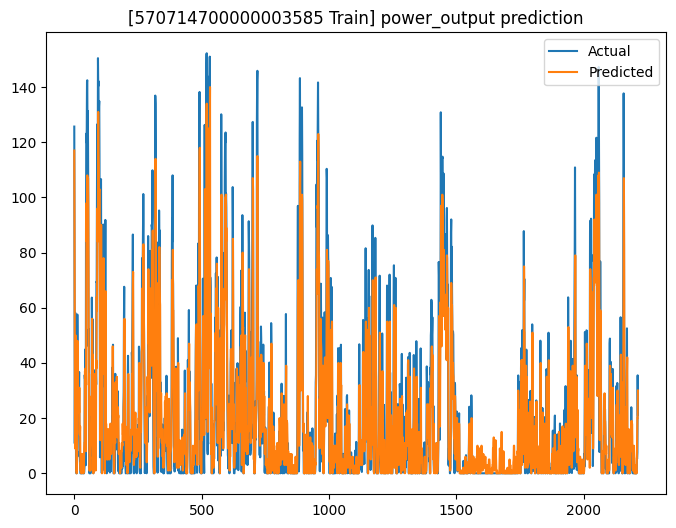

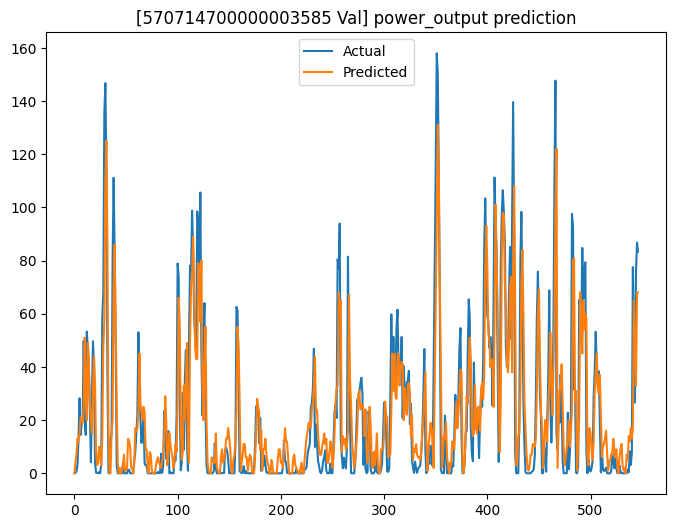

INFO logger 2025-10-21 14:18:56,962 | helpers.py:60 | Metrics for dimension: 0
	mse: 273.87890625, rmse: 16.549287182534478, mae: 10.424253463745117, r^2: 0.7371389865875244, nrmse: 0.7779207425315283
INFO logger 2025-10-21 14:18:56,963 | helpers.py:60 | Metrics for dimension: 0
	mse: 381.5129089355469, rmse: 19.532355437467004, mae: 12.486886978149414, r^2: 0.6712954044342041, nrmse: 0.7920238100746766



Final Prediction on 570714700000005053 (Inference Stage)
[Train]: mse: 273.87890625, rmse: 16.549287182534478, mae 10.424253463745117, r2: 0.7371389865875244, nrmse: 0.7779207425315283
[Val]: mse: 381.5129089355469, rmse: 19.532355437467004, mae 12.486886978149414, r2: 0.6712954044342041, nrmse: 0.7920238100746766




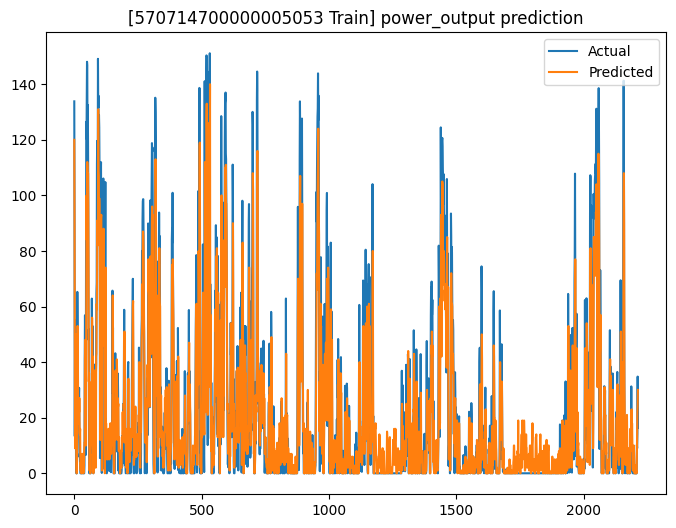

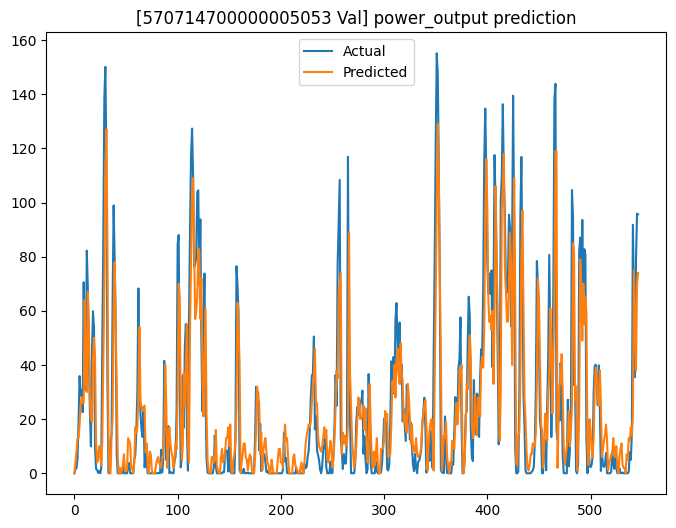

INFO logger 2025-10-21 14:18:57,083 | helpers.py:60 | Metrics for dimension: 0
	mse: 256.9632568359375, rmse: 16.03007351311707, mae: 9.9005708694458, r^2: 0.6603631973266602, nrmse: 0.8898879697626435
INFO logger 2025-10-21 14:18:57,084 | helpers.py:60 | Metrics for dimension: 0
	mse: 384.1311950683594, rmse: 19.599265166540285, mae: 13.427645683288574, r^2: 0.6714505553245544, nrmse: 0.7780255422554382
INFO logger 2025-10-21 14:18:57,087 | helpers.py:60 | Metrics for dimension: 0
	mse: 273.5000915527344, rmse: 16.537838176519156, mae: 10.44029426574707, r^2: 0.6891744136810303, nrmse: 0.8353497195786843
INFO logger 2025-10-21 14:18:57,088 | helpers.py:60 | Metrics for dimension: 0
	mse: 428.28814697265625, rmse: 20.69512374866737, mae: 13.939836502075195, r^2: 0.67051100730896, nrmse: 0.7707397377546381
INFO logger 2025-10-21 14:18:57,090 | helpers.py:60 | Metrics for dimension: 0
	mse: 232.97998046875, rmse: 15.263681746837818, mae: 10.049332618713379, r^2: 0.6622856259346008, nrmse


Final Prediction on 570714700000010750 (Inference Stage)
[Train]: mse: 256.9632568359375, rmse: 16.03007351311707, mae 9.9005708694458, r2: 0.6603631973266602, nrmse: 0.8898879697626435
[Val]: mse: 384.1311950683594, rmse: 19.599265166540285, mae 13.427645683288574, r2: 0.6714505553245544, nrmse: 0.7780255422554382



Final Prediction on 570714700000010767 (Inference Stage)
[Train]: mse: 273.5000915527344, rmse: 16.537838176519156, mae 10.44029426574707, r2: 0.6891744136810303, nrmse: 0.8353497195786843
[Val]: mse: 428.28814697265625, rmse: 20.69512374866737, mae 13.939836502075195, r2: 0.67051100730896, nrmse: 0.7707397377546381



Final Prediction on 570714700000004728 (Inference Stage)
[Train]: mse: 232.97998046875, rmse: 15.263681746837818, mae 10.049332618713379, r2: 0.6622856259346008, nrmse: 0.7108579548764198
[Val]: mse: 295.8321838378906, rmse: 17.19977278448441, mae 11.4111967086792, r2: 0.6671904921531677, nrmse: 0.7356711846957681



Final Prediction on 570714700000005039 

INFO logger 2025-10-21 14:18:57,170 | helpers.py:60 | Metrics for dimension: 0
	mse: 171.14051818847656, rmse: 13.082068574521255, mae: 8.653478622436523, r^2: -1.8836381435394287, nrmse: 15.48586648904839
INFO logger 2025-10-21 14:18:57,175 | helpers.py:60 | Metrics for dimension: 0
	mse: 21543.0390625, rmse: 146.77547159692588, mae: 29.63431167602539, r^2: 0.6009796857833862, nrmse: 4.704550723211205
INFO logger 2025-10-21 14:18:57,179 | helpers.py:60 | Metrics for dimension: 0
	mse: 186.64480590820312, rmse: 13.66180097601349, mae: 8.728418350219727, r^2: 0.7443856000900269, nrmse: 0.8510270243622347
INFO logger 2025-10-21 14:18:57,181 | helpers.py:60 | Metrics for dimension: 0
	mse: 216.5601348876953, rmse: 14.715982294352468, mae: 10.463930130004883, r^2: 0.7170091867446899, nrmse: 1.0156315195320194
INFO logger 2025-10-21 14:18:57,184 | helpers.py:60 | Metrics for dimension: 0
	mse: 319.84356689453125, rmse: 17.884170847275286, mae: 11.529587745666504, r^2: 0.7073462009429932, nr


Final Prediction on 570714700000008627 (Inference Stage)
[Train]: mse: 171.14051818847656, rmse: 13.082068574521255, mae 8.653478622436523, r2: -1.8836381435394287, nrmse: 15.48586648904839
[Val]: mse: 21543.0390625, rmse: 146.77547159692588, mae 29.63431167602539, r2: 0.6009796857833862, nrmse: 4.704550723211205



Final Prediction on 570714700000008962 (Inference Stage)
[Train]: mse: 186.64480590820312, rmse: 13.66180097601349, mae 8.728418350219727, r2: 0.7443856000900269, nrmse: 0.8510270243622347
[Val]: mse: 216.5601348876953, rmse: 14.715982294352468, mae 10.463930130004883, r2: 0.7170091867446899, nrmse: 1.0156315195320194



Final Prediction on 570714700000009556 (Inference Stage)
[Train]: mse: 319.84356689453125, rmse: 17.884170847275286, mae 11.529587745666504, r2: 0.7073462009429932, nrmse: 0.6384168363066295
[Val]: mse: 437.7499694824219, rmse: 20.92247522360636, mae 13.368729591369629, r2: 0.6956467628479004, nrmse: 0.6337191791794484



Final Prediction on 57071470000000

INFO logger 2025-10-21 14:18:57,291 | helpers.py:60 | Metrics for dimension: 0
	mse: 386.80224609375, rmse: 19.66728873265835, mae: 12.853678703308105, r^2: 0.717572808265686, nrmse: 0.6298306483086746
INFO logger 2025-10-21 14:18:57,293 | helpers.py:60 | Metrics for dimension: 0
	mse: 509.39532470703125, rmse: 22.56978787465738, mae: 14.661623001098633, r^2: 0.713080883026123, nrmse: 0.6311532924551122
INFO logger 2025-10-21 14:18:57,295 | helpers.py:60 | Metrics for dimension: 0
	mse: 332.15545654296875, rmse: 18.225132552137136, mae: 11.880684852600098, r^2: 0.7496781349182129, nrmse: 0.7467971726846261
INFO logger 2025-10-21 14:18:57,296 | helpers.py:60 | Metrics for dimension: 0
	mse: 542.499267578125, rmse: 23.291613674842818, mae: 15.32583999633789, r^2: 0.6906827688217163, nrmse: 0.7975818141983573
INFO logger 2025-10-21 14:18:57,298 | helpers.py:60 | Metrics for dimension: 0
	mse: 270.7544250488281, rmse: 16.454617134677676, mae: 10.703795433044434, r^2: 0.7368992567062378, nr


Final Prediction on 570715000000088513 (Inference Stage)
[Train]: mse: 250.5807342529297, rmse: 15.829742077902901, mae 10.02783489227295, r2: 0.6833674907684326, nrmse: 1.150440724959656
[Val]: mse: 505.5503234863281, rmse: 22.484446257053524, mae 14.710232734680176, r2: 0.6601863503456116, nrmse: 0.6151555447487256



Final Prediction on 570714700000007651 (Inference Stage)
[Train]: mse: 386.80224609375, rmse: 19.66728873265835, mae 12.853678703308105, r2: 0.717572808265686, nrmse: 0.6298306483086746
[Val]: mse: 509.39532470703125, rmse: 22.56978787465738, mae 14.661623001098633, r2: 0.713080883026123, nrmse: 0.6311532924551122



Final Prediction on 570714700000012624 (Inference Stage)
[Train]: mse: 332.15545654296875, rmse: 18.225132552137136, mae 11.880684852600098, r2: 0.7496781349182129, nrmse: 0.7467971726846261
[Val]: mse: 542.499267578125, rmse: 23.291613674842818, mae 15.32583999633789, r2: 0.6906827688217163, nrmse: 0.7975818141983573



Final Prediction on 570714700000008

INFO logger 2025-10-21 14:18:57,391 | helpers.py:60 | Metrics for dimension: 0
	mse: 464.1675720214844, rmse: 21.544548545316154, mae: 14.147407531738281, r^2: 0.7287588119506836, nrmse: 0.6376457167205859
INFO logger 2025-10-21 14:18:57,405 | helpers.py:60 | Metrics for dimension: 0
	mse: 516.0408325195312, rmse: 22.71653214114186, mae: 14.606743812561035, r^2: 0.6939445734024048, nrmse: 0.6409969410420304
INFO logger 2025-10-21 14:18:57,414 | helpers.py:60 | Metrics for dimension: 0
	mse: 965.9052734375, rmse: 31.079016609884874, mae: 23.692800521850586, r^2: 0.34211665391921997, nrmse: 0.7176372421716672
INFO logger 2025-10-21 14:18:57,418 | helpers.py:60 | Metrics for dimension: 0
	mse: 274.3600158691406, rmse: 16.563816464484887, mae: 12.554593086242676, r^2: -0.26271629333496094, nrmse: 2.6703127483612796
INFO logger 2025-10-21 14:18:57,431 | helpers.py:60 | Metrics for dimension: 0
	mse: 534.5274658203125, rmse: 23.11985003888028, mae: 15.25147819519043, r^2: 0.7348694205284119,


Final Prediction on 570714700000008955 (Inference Stage)
[Train]: mse: 464.1675720214844, rmse: 21.544548545316154, mae 14.147407531738281, r2: 0.7287588119506836, nrmse: 0.6376457167205859
[Val]: mse: 516.0408325195312, rmse: 22.71653214114186, mae 14.606743812561035, r2: 0.6939445734024048, nrmse: 0.6409969410420304



Final Prediction on 570714700000006876 (Inference Stage)
[Train]: mse: 965.9052734375, rmse: 31.079016609884874, mae 23.692800521850586, r2: 0.34211665391921997, nrmse: 0.7176372421716672
[Val]: mse: 274.3600158691406, rmse: 16.563816464484887, mae 12.554593086242676, r2: -0.26271629333496094, nrmse: 2.6703127483612796



Final Prediction on 570714700000009037 (Inference Stage)
[Train]: mse: 534.5274658203125, rmse: 23.11985003888028, mae 15.25147819519043, r2: 0.7348694205284119, nrmse: 0.6090612951979826
[Val]: mse: 573.07861328125, rmse: 23.939060409323712, mae 15.584707260131836, r2: 0.6959280967712402, nrmse: 0.6074302580206353



Final Prediction on 570714700000

In [42]:
inference(
    global_model,
    {cid: client_X_train[cid] for cid in valid_clients},
    {cid: client_y_train[cid] for cid in valid_clients},
    {cid: client_X_val[cid] for cid in valid_clients},
    {cid: client_y_val[cid] for cid in valid_clients},
    exogenous_data_train, 
    exogenous_data_val,
    {cid: y_scalers[cid] for cid in valid_clients}
)